In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

In [100]:
input_transform = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.RandomCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

output_transform = transforms.Compose([
    transforms.CenterCrop((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

training_data = datasets.Flowers102(root="data", split="train", download=True, transform=input_transform)
validation_data = datasets.Flowers102(root="data", split="val", download=True, transform=output_transform)
test_data = datasets.Flowers102(root="data", split="test", download=True, transform=output_transform)

In [96]:
len(training_data), len(validation_data), len(test_data)

(1020, 1020, 6149)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


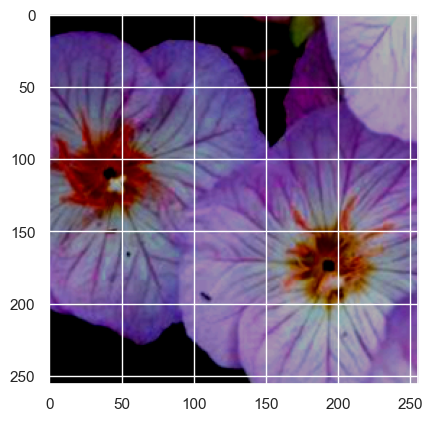

In [101]:
plt.imshow(training_data[0][0].permute(1, 2, 0))

In [102]:
batch_size = 32
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [103]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()

class FlowersModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 16, 9, padding=4, stride=2)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64 * 16 * 16, 256)
        self.final = nn.Linear(256, 102)
        self.softmax = nn.LogSoftmax(dim=1)
        self.output = nn.Sequential(
            self.conv1,
            self.relu,
            self.pool1,
            self.conv2,
            self.relu,
            self.pool2,
            self.conv3,
            self.relu,
            self.pool2,
            self.flatten,
            self.dropout,
            self.linear,
            self.relu,
            self.dropout,
            self.final,
            self.softmax
        )

    def forward(self, x):
        return self.output(x)

    def get_first_conv_output(self, x):
        return self.relu(self.conv1(x))

    def get_second_conv_output(self, x):
        x = self.relu(self.conv1(x))
        return self.relu(self.conv2(self.pool1(x)))

    def get_third_conv_output(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(self.pool1(x)))
        return self.relu(self.conv3(self.pool2(x)))

model = FlowersModel().to(device)
model

FlowersModel(
  (relu): ReLU()
  (conv1): Conv2d(3, 16, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=16384, out_features=256, bias=True)
  (final): Linear(in_features=256, out_features=102, bias=True)
  (softmax): LogSoftmax(dim=1)
  (output): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_

In [104]:
learning_rate = 0.0005
loss_fn = nn.NLLLoss()
optimiser = torch.optim.AdamW(model.parameters(), learning_rate)

In [88]:
def train(dataloader: DataLoader, training_model: nn.Module, optim: torch.optim.Optimizer):
    size = len(dataloader.dataset)
    training_model.train()
    for batch_no, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred = training_model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optim.step()

        if batch_no % 10 == 0:
            loss, current = loss.item(), (batch_no + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

def test(dataloader:DataLoader, eval_model: nn.Module, losses: list, accuracy: list):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = eval_model(X)
            total_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    total_loss /= num_batches
    correct /= size

    losses.append(total_loss)
    accuracy.append(100 * correct)

    print(f"Accuracy: {(100 * correct):>0.1f}%, Avg loss: {total_loss:>8f} \n")


In [105]:
epochs = 120
val_losses = []
val_accuracy = []
train_losses = []
train_accuracy = []
epoch_list = []

for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, optimiser)
    print("Validation Error:")
    test(val_dataloader, model, val_losses, val_accuracy)
    print("Training Error:")
    test(train_dataloader, model, train_losses, train_accuracy)
    epoch_list.append(t+1)

    # epoch_list.append(t)

print("Done!")


Epoch 1
-------------------------------
loss: 4.627147 [   32/ 1020]
loss: 4.632901 [  352/ 1020]
loss: 4.619663 [  672/ 1020]
loss: 4.621773 [  992/ 1020]
Validation Error:
Accuracy: 1.3%, Avg loss: 4.594594 

Training Error:
Accuracy: 1.6%, Avg loss: 4.605816 

Epoch 2
-------------------------------
loss: 4.612830 [   32/ 1020]
loss: 4.575342 [  352/ 1020]
loss: 4.507241 [  672/ 1020]
loss: 4.485514 [  992/ 1020]
Validation Error:
Accuracy: 2.0%, Avg loss: 4.382882 

Training Error:
Accuracy: 2.1%, Avg loss: 4.467782 

Epoch 3
-------------------------------
loss: 4.461292 [   32/ 1020]
loss: 4.414530 [  352/ 1020]
loss: 4.210664 [  672/ 1020]
loss: 4.488283 [  992/ 1020]
Validation Error:
Accuracy: 3.4%, Avg loss: 4.256179 

Training Error:
Accuracy: 2.8%, Avg loss: 4.361963 

Epoch 4
-------------------------------
loss: 4.371069 [   32/ 1020]
loss: 4.308883 [  352/ 1020]
loss: 4.316140 [  672/ 1020]
loss: 4.232768 [  992/ 1020]
Validation Error:
Accuracy: 5.5%, Avg loss: 4.148578

KeyboardInterrupt: 

In [73]:
print("Testing error:")
test(test_dataloader, model, [], [])

Testing error:
Accuracy: 33.8%, Avg loss: 3.358366 



(0.0, 5.0)

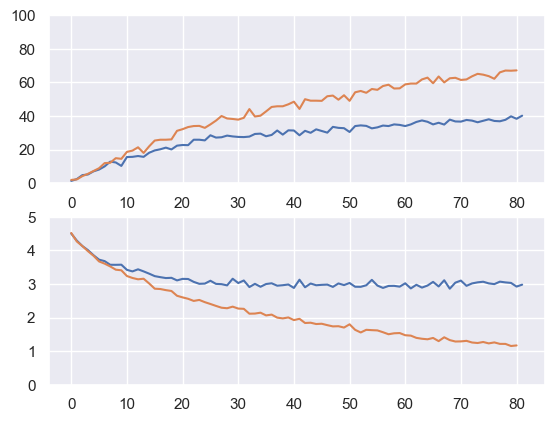

In [72]:
sns.set()
# epoch_list.append(31)
f, ax = plt.subplots(2, 1)
# ax[0].plot(epoch_list, test_accuracy)
ax[0].plot(val_accuracy)
ax[0].plot(train_accuracy)
ax[0].set_ylim(0, 100)
# ax[1].plot(epoch_list, test_losses)
ax[1].plot(val_losses)
ax[1].plot(train_losses)
ax[1].set_ylim(0, 5)
# f.show()

In [ ]:
# torch.save(model.state_dict(), "model-35percent.pth")
print("Saved PyTorch Model State to model.pth")


In [106]:
single_dataloader = DataLoader(test_data, 1, shuffle=True)
with torch.no_grad():
    for x, y in single_dataloader:
        x, y = x.to(device), y.to(device)
        first_conv = model.get_first_conv_output(x)
        second_conv = model.get_second_conv_output(x)
        third_conv = model.get_third_conv_output(x)
        pred = model(x)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


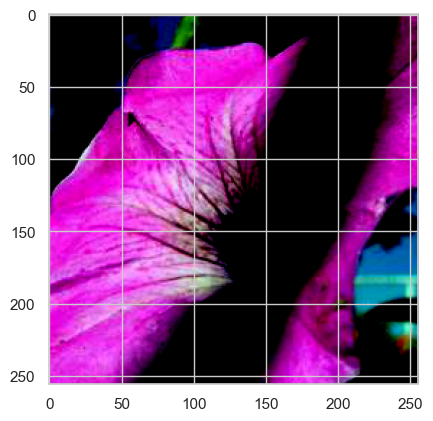

In [110]:
plt.imshow(x[0].to("cpu").permute(1, 2, 0))

<Figure size 640x480 with 0 Axes>

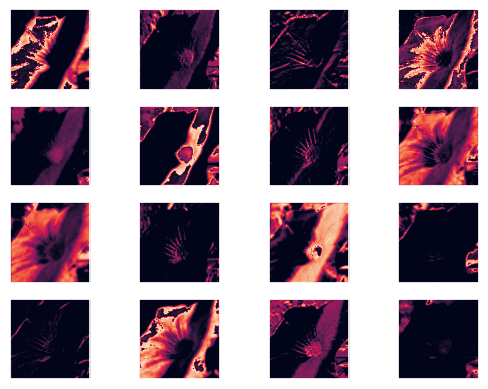

In [108]:
# print(pred[0].argmax(), y[0])
from torchvision.transforms.functional import to_pil_image
plt.tight_layout()
f, ax = plt.subplots(4, 4, squeeze=False)
for i in range(4):
    for j in range(4):
        img = to_pil_image(first_conv.to("cpu")[0][i * 4 + j])
        ax[i, j].imshow(img)
        ax[i, j].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


<Figure size 640x480 with 0 Axes>

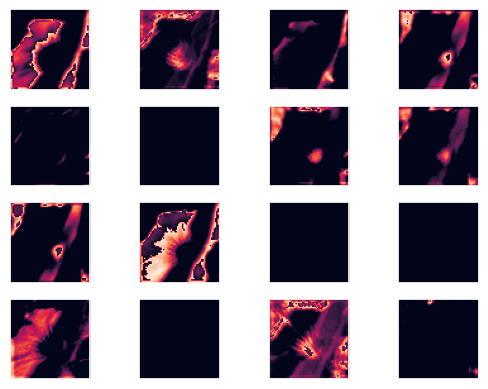

In [109]:
from torchvision.transforms.functional import to_pil_image
plt.tight_layout()
f, ax = plt.subplots(4, 4, squeeze=False)
for i in range(4):
    for j in range(4):
        img = to_pil_image(second_conv.to("cpu")[0][i * 4 + j])
        ax[i, j].imshow(img)
        ax[i, j].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

<Figure size 640x480 with 0 Axes>

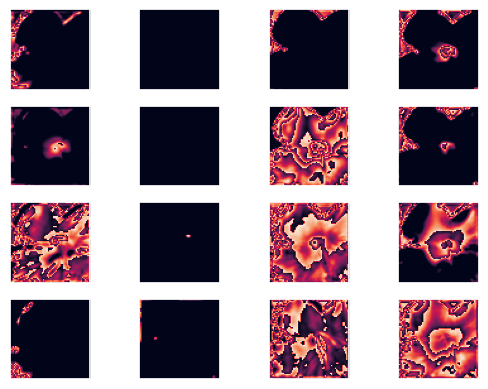

In [64]:
from torchvision.transforms.functional import to_pil_image
plt.tight_layout()
f, ax = plt.subplots(4, 4, squeeze=False)
for i in range(4):
    for j in range(4):
        img = to_pil_image(second_conv.to("cpu")[0][16 + i * 4 + j])
        ax[i, j].imshow(img)
        ax[i, j].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])